In [1]:
from __future__ import division, print_function
import os
import sys
path = "/Users/adrian/projects/ophiuchus/build/lib.macosx-10.5-x86_64-2.7/"
if path not in sys.path:
    sys.path.append(path)
    
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

# Custom
import gary.dynamics as gd
import gary.integrate as gi
import gary.potential as gp
from gary.units import galactic

from ophiuchus import barred_mw, static_mw
import ophiuchus.potential as op

plotpath = "/Users/adrian/projects/ophiuchus-paper/figures/"
if not os.path.exists(plotpath):
    os.mkdir(plotpath)

In [2]:
potential_classes = dict(
    spheroid=gp.HernquistPotential,
    disk=gp.MiyamotoNagaiPotential,
    halo=gp.FlattenedNFWPotential,
    bar=op.WangZhaoBarPotential
)

In [3]:
(0.19*u.kpc/u.Myr).to(u.km/u.s)

<Quantity 185.7805221178944 km / s>

---

In [8]:
def density_on_grid(potential, grid_lim=(-15,15), ngrid=128):
    grid = np.linspace(grid_lim[0], grid_lim[1], ngrid)
    xyz = np.vstack(map(np.ravel, np.meshgrid(grid,grid,grid))).T

    val = np.zeros((ngrid*ngrid*ngrid,))
    val = potential.density(xyz)
    val[np.isnan(val)] = val[np.isfinite(val)].max()
    
    gridx = xyz[:,0].reshape(ngrid,ngrid,ngrid)[:,:,0]
    gridy = xyz[:,1].reshape(ngrid,ngrid,ngrid)[:,:,0]
    
    return gridx, gridy, val

In [38]:
ngrid = 128
xx,yy,barred_dens = density_on_grid(barred_mw, ngrid=ngrid)
xx,yy,static_dens = density_on_grid(static_mw, ngrid=ngrid)

## Surface density plots

In [39]:
def side_by_side_surface_dens(xx, yy, dens):
    ngrid = xx.shape[0]
    
    fig,axes = pl.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

    axes[0].pcolormesh(xx, yy, dens.reshape(ngrid,ngrid,ngrid).sum(axis=2), 
                       cmap='Greys_r',
                       norm=mpl.colors.LogNorm(),
                       vmin=1E7, vmax=5E9)
    axes[0].text(-8., 0, r"$\odot$", ha='center', va='center', fontsize=18, color='w')

    axes[1].pcolormesh(xx, yy, dens.reshape(ngrid,ngrid,ngrid).sum(axis=0).T, 
                       cmap='Greys_r',
                       norm=mpl.colors.LogNorm(),
                       vmin=1E7, vmax=5E9)

    axes[0].set_xlim(xx.min(), xx.max())
    axes[0].set_ylim(yy.min(), yy.max())

    # TODO: fix the damn aspect ratio
#     for ax in axes:
#         ax.set_aspect('equal')
    fig.tight_layout()
    
    return fig

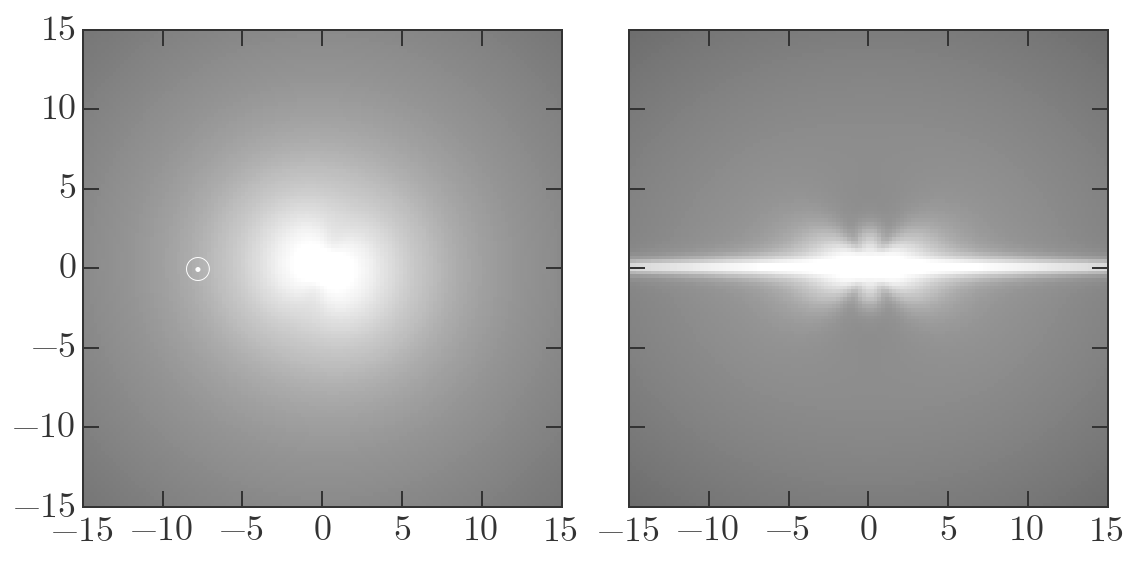

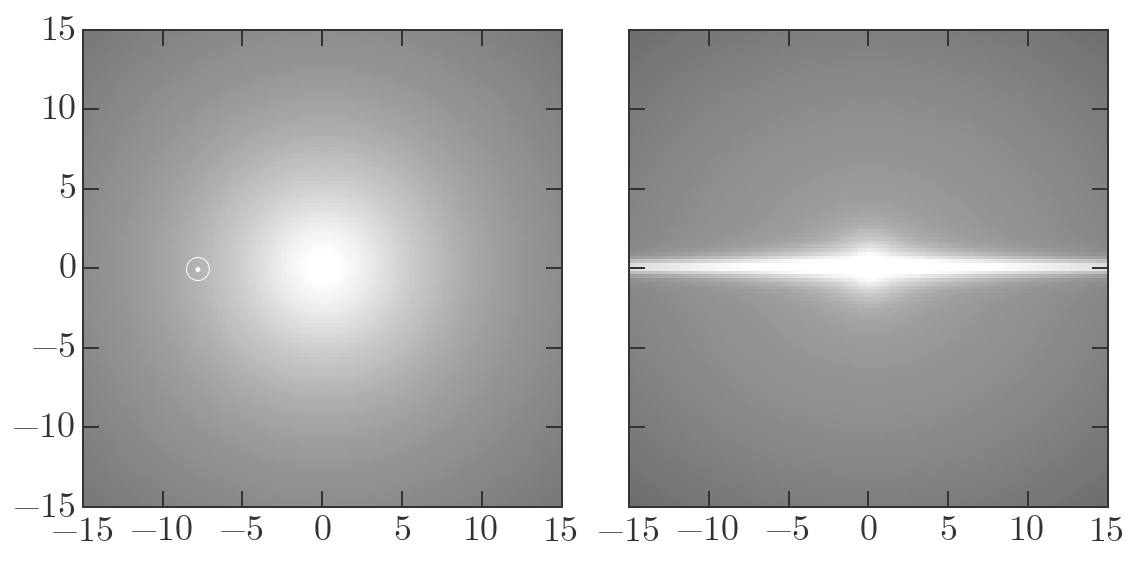

In [40]:
fig = side_by_side_surface_dens(xx, yy, barred_dens)
fig = side_by_side_surface_dens(xx, yy, static_dens)

## Contour plots

In [41]:
def side_by_side_contour_plots(xx, yy, dens, levels=10**np.arange(7,12,0.25)):
    ngrid = xx.shape[0]
    
    fig,axes = pl.subplots(1,2,figsize=(7.8,4),sharex=True,sharey=True)

    im = axes[0].contour(xx, yy, dens.reshape(ngrid,ngrid,ngrid).sum(axis=2), 
                         colors='k',
                         levels=levels,
                         rasterized=True)
    axes[0].text(-8., 0, r"$\odot$", ha='center', va='center', fontsize=18)

    _ = axes[1].contour(xx, yy, dens.reshape(ngrid,ngrid,ngrid).sum(axis=0).T, 
                        colors='k',
                        levels=levels,
                        rasterized=True)


    # fig.subplots_adjust(bottom=0.2, right=0.85, wspace=0.25)

    for ax in axes:
        ax.xaxis.set_ticks([-10,0,10])
        ax.yaxis.set_ticks([-10,0,10])

    axes[0].set_xlabel("$x$ [kpc]")
    axes[0].set_ylabel("$y$ [kpc]")
    axes[1].set_xlabel("$y$ [kpc]")
    axes[1].set_ylabel("$z$ [kpc]")

    axes[0].set_xlim(xx.min(), xx.max())
    axes[0].set_ylim(yy.min(), yy.max())

    fig.tight_layout()
    
    return fig

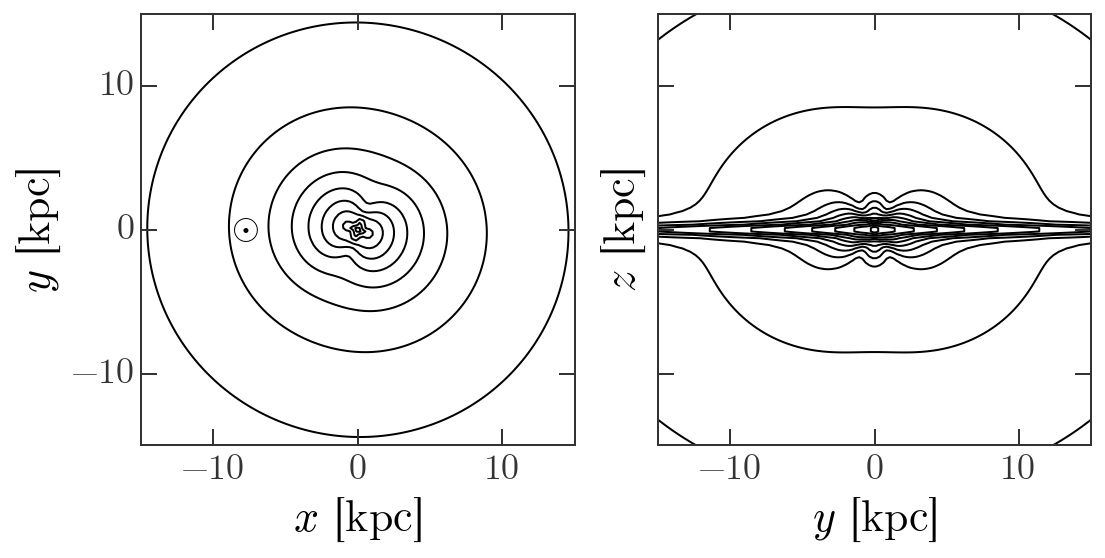

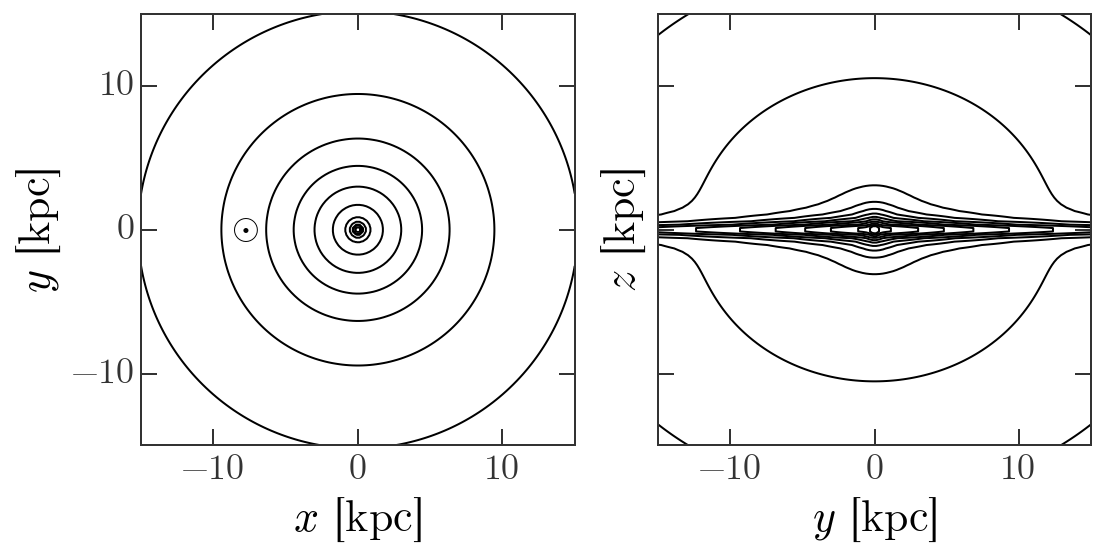

In [42]:
barred_fig = side_by_side_contour_plots(xx, yy, barred_dens)
static_fig = side_by_side_contour_plots(xx, yy, static_dens)

# barred_fig.savefig(os.path.join(plotpath, "barred-surface-density-contour.pdf"), bbox_inches='tight')
barred_fig.savefig(os.path.join(plotpath, "barred-surface-density-contour.png"), dpi=400, bbox_inches='tight')

# static_fig.savefig(os.path.join(plotpath, "static-surface-density-contour.pdf"), bbox_inches='tight')
static_fig.savefig(os.path.join(plotpath, "static-surface-density-contour.png"), dpi=400, bbox_inches='tight')

## Portail et al. (2015)

In [31]:
ngrid = 65
grid = np.linspace(-2,2,ngrid)
xyz = np.vstack(map(np.ravel, np.meshgrid(grid,grid,grid))).T

val2 = np.zeros((ngrid*ngrid*ngrid,))
# for k in potentials.keys():
#     val += potentials[k].density(xyz)
val2 += potentials['bar'].density(xyz)
val2[np.isnan(val2)] = val2[np.isfinite(val2)].max()

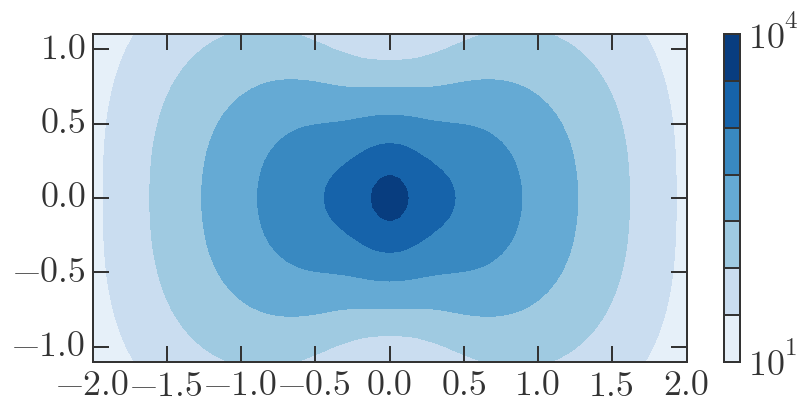

In [32]:
surf_dens = (val2.reshape(ngrid,ngrid,ngrid).sum(axis=1).T*u.Msun/(u.kpc**2)/ngrid).to(u.Msun/u.pc**2)

pl.figure(figsize=(6,3))
pl.contourf(xyz[:,0].reshape(ngrid,ngrid,ngrid)[:,:,0],
            xyz[:,1].reshape(ngrid,ngrid,ngrid)[:,:,0],
            surf_dens.value,
            norm=mpl.colors.LogNorm(),
            levels=np.logspace(1., 4, 8),
            cmap='Blues')
#               cmap='Greys_r',
#               norm=mpl.colors.LogNorm(),
#               vmin=5E8, vmax=5E10)
pl.xlim(-2,2)
pl.ylim(-1.1,1.1)
pl.colorbar()
pl.tight_layout()

## Circular velocity curve

In [3]:
def circ_vel_plot(potential):
    rr = np.linspace(0.1, 20., 1024)
    xyz = np.zeros((len(rr), 3))
    xyz[:,0] = rr
    
    potentials = dict()
    for k,P in potential_classes.items():
        potentials[k] = P(units=galactic, **potential.parameters[k])

    # vcirc = (np.sqrt(potential.G * potential.mass_enclosed(xyz) / rr)*u.kpc/u.Myr).to(u.km/u.s).value
    vcirc = (np.sqrt(potential.G * np.sum([p.mass_enclosed(xyz) for p in potentials.values()], axis=0) / rr)*u.kpc/u.Myr).to(u.km/u.s).value

    fig,ax = pl.subplots(1,1,figsize=(6,5))
    ax.plot(rr, vcirc, marker=None, lw=3.)

    styles = dict(
        halo=dict(lw=2, ls='-.'),
        bar=dict(lw=3., ls=':'),
        spheroid=dict(lw=3., ls=':'),
        disk=dict(lw=2., ls='--')
    )
    for k,p in potentials.items():
#         if k == 'spheroid':
        if k != 'halo' and potential.parameters[k]['m'] == 0:
            continue
        
        if k == 'spheroid':
            disk_other = 'Spher'
        elif k =='bar':
            disk_other = 'Bar'

        vc = (np.sqrt(potential.G * p.mass_enclosed(xyz) / rr)*u.kpc/u.Myr).to(u.km/u.s).value
        ax.plot(rr, vc, marker=None, label=k.capitalize(), **styles[k])
    
    if disk_other == 'Bar':
        vc = (np.sqrt(potential.G * (potentials['bar'].mass_enclosed(xyz)+potentials['disk'].mass_enclosed(xyz)) / rr)*u.kpc/u.Myr).to(u.km/u.s).value
    elif disk_other == 'Spher':
        vc = (np.sqrt(potential.G * (potentials['spheroid'].mass_enclosed(xyz)+potentials['disk'].mass_enclosed(xyz)) / rr)*u.kpc/u.Myr).to(u.km/u.s).value
    ax.plot(rr, vc, marker=None, label='Disk+{}'.format(disk_other), lw=2.)

    ax.set_xlabel("$x$ [kpc]")
    ax.set_ylabel(r"$v_c$ [${\rm km}\,{\rm s}^{-1}$]")

    ax.legend(loc='lower right', fontsize=14)
    ax.set_ylim(0,300)
    # ax.set_ylim(150,300)
    # ax.axhline(220, alpha=0.2, lw=1.)
    # ax.axvline(8., color='#cccccc', lw=2., zorder=-100)

    rcolor = '#dddddd'
    rect = mpl.patches.Rectangle((0.,215), rr.max(), 20., zorder=-100, color=rcolor)
    ax.add_patch(rect)
    rect2 = mpl.patches.Rectangle((8.,0), 0.3, ax.get_ylim()[1], zorder=-100, color=rcolor)
    ax.add_patch(rect2)

    fig.tight_layout()
    
    return fig

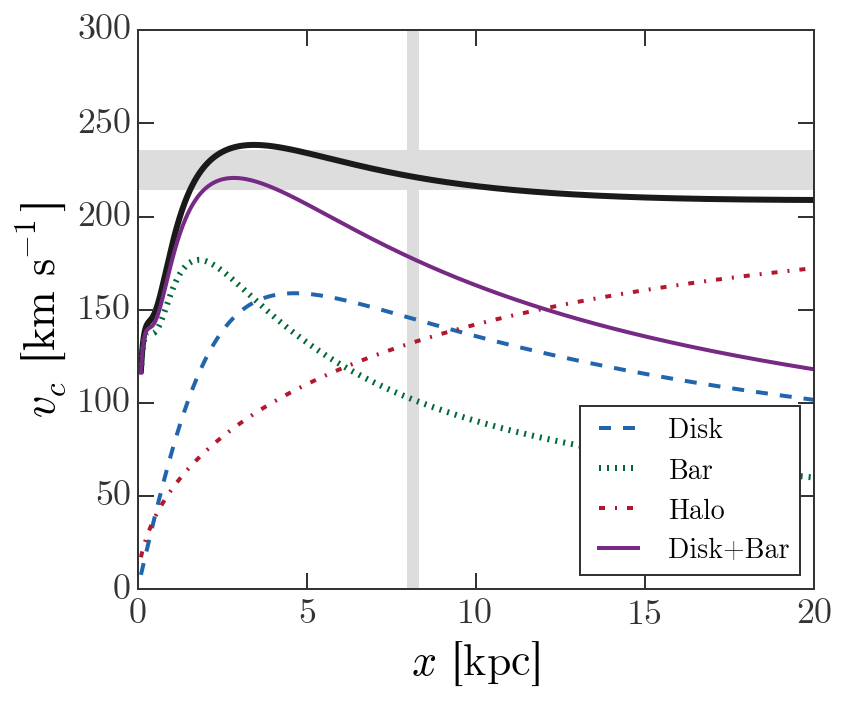

In [45]:
fig = circ_vel_plot(barred_mw)
# fig.savefig(os.path.join(plotpath, "barred-circ-vel.pdf"))
fig.savefig(os.path.join(plotpath, "barred-circ-vel.png"), dpi=400)

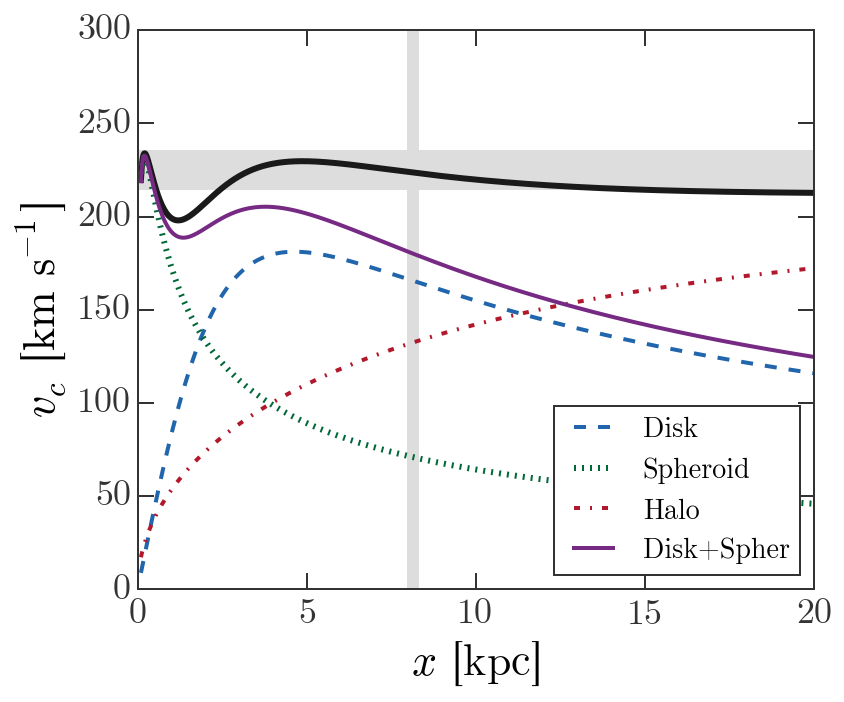

In [4]:
fig = circ_vel_plot(static_mw)
# fig.savefig(os.path.join(plotpath, "static-circ-vel.pdf"))
fig.savefig(os.path.join(plotpath, "static-circ-vel.png"), dpi=400)